Velocity field has shape:(375, 64, 32, 2)


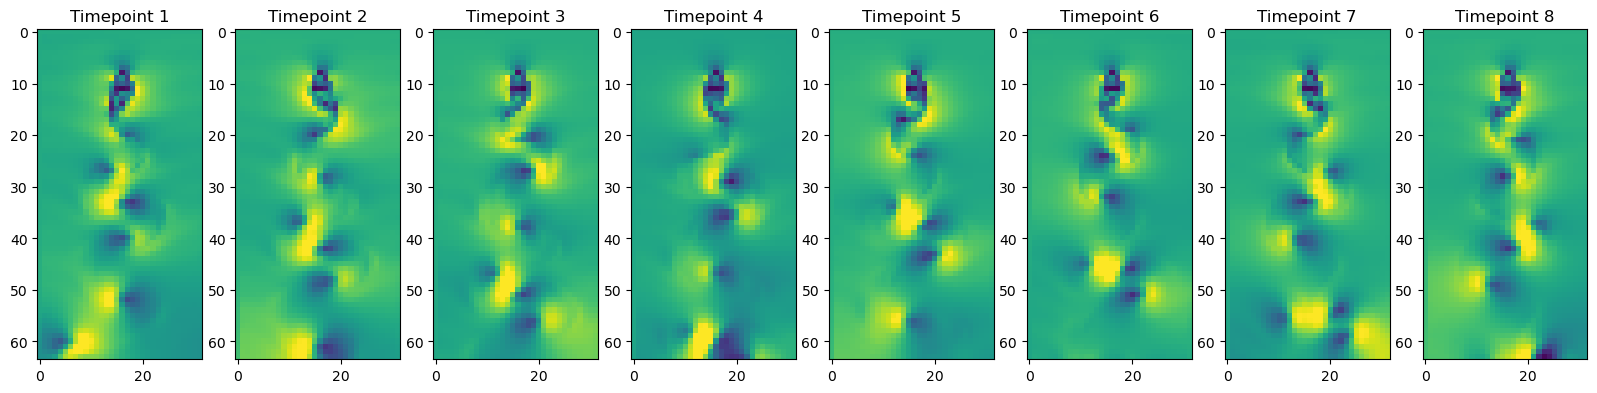

In [3]:
import numpy as np
import matplotlib.pyplot as plt
Re = 600
vfield = np.load(f"vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
vfield = vfield[::8,::4,::4]

print("Velocity field has shape:{}".format(vfield.shape))

vfield_mag = np.sqrt(vfield[...,0]**2 + vfield[...,1]**2)

n_pts = vfield.shape[0]
plt.figure(figsize = (20,10))
for i in range(8):
    plt.subplot(1,8,i+1)
    v_vals = vfield_mag[n_pts//8 * i]
    plt.imshow(v_vals,cmap = "viridis", vmin = 0, vmax = np.percentile(v_vals,99))
    plt.title("Timepoint {}".format(i+1))

In [4]:
class ForecastingDataset:

    def __init__(self, X, split_ratio=(0.6, 0.2, 0.2), forecast_horizon=1, featurizer=None):
    

        if featurizer is None:
        
            self.featurizer = lambda x: x
        else:
            self.featurizer = featurizer

        self.feature_shape = X.shape[1:]

        # We need to ensure that datapoints don't appear in multiple splits, hence why
        # we crop by the forecast horizon. We are going to do one-step forecasting
        self.X_full = self.featurizer(X[:-1])#[:-forecast_horizon]
        self.y_full = X[1:]#[forecast_horizon:]
        self.forecast_horizon = forecast_horizon

        # Split the data into train, val, test
        n_train = int(len(self.X_full) * split_ratio[0])
        n_val = int(len(self.X_full) * split_ratio[1])
        n_test = len(self.X_full) - n_train - n_val

        # Our frequent use of the forecast_horizon parameter again arises from our need
        # to ensure that datapoints don't appear in multiple splits.
        self.X_train, self.y_train = self.X_full[:n_train], self.y_full[:n_train]
        self.X_val, self.y_val = (
            self.X_full[n_train + forecast_horizon : n_train + forecast_horizon + n_val], # 1 - 600, 2 - 601 | 601 - 800
            self.y_full[n_train+ forecast_horizon:n_train + forecast_horizon + n_val]
        )
        self.X_test, self.y_test = (
            self.X_full[n_train + 2 * forecast_horizon+ n_val:], 
            self.y_full[n_train + 2 * forecast_horizon + n_val:]
        )

    def __len__(self):
        return len(self.X_full)

    def __getitem__(self, idx):
        return self.X_full[idx], self.y_full[idx]

    def flatten_data(self, x):
        """
        Given a dataset, transform into a flat feature form
        """
        return np.reshape(x, (x.shape[0], -1))

    def unflatten_data(self, x):
        """
        Given a flat dataset, convert back to the original shape
        """
        out = np.reshape(x, (x.shape[0], *self.feature_shape))
        return out

In [5]:
# Let's do a simple unit test to make sure that our class is working as expected
# Take some time to understand what these test cases cover
import unittest
class TestForecastingDataset(unittest.TestCase):

    def test_initialization(self):
        fd = ForecastingDataset(np.arange(100)[:, None])
        assert fd.y_train[0] == fd.X_train[1], "y_train is not shifted by 1 from X_train"
        assert fd.y_val[0] == fd.X_val[1], "y_val is not shifted by 1 from X_val"
        assert fd.y_test[0] == fd.X_test[1], "y_test is not shifted by 1 from X_test"
        
        assert fd.y_train[-1] < fd.y_val[0], "y_train and y_test are not disjoint"
        assert fd.y_val[-1] < fd.y_test[0], "y_val and y_test are not disjoint"
    
unittest.main(argv=[''], exit=False);

    # test split_size
    

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


In [17]:
import numpy as np
import warnings
import matplotlib.pyplot as plt


class BaseRegressor:
    """
    A base class for regression models.
    """
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Fits the model to the data.
        """
        raise NotImplementedError("Subclasses must implement this method")

    def predict(self, X):
        
        return X @ self.weights + self.bias
        

    def score(self, X, y):
       
        return np.mean((self.predict(X) - y)**2)

In [18]:
class LinearRegressor(BaseRegressor):
    
    
    def __init__(self, method="global", regularization="ridge", regstrength=0.1, **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    def _fit_global(self, X, y):
       
        I = np.eye(X.shape[1])
        
        if self.regularization == None:
            self.weights = np.linalg.inv(X.T@X)@ X.T @ y
        elif self.regularization == "ridge":    
            self.weights = np.linalg.inv(X.T@X + I)*self.regstrength @ X.T @ y
        else:
            self.weights = np.linalg.inv(X.T@X)@ X.T @ y
            
        self.bias = np.mean(y - X@self.weights)
        
        return self.weights, self.bias

    def _fit_iterative(self, X, y, learning_rate=0.01):
        
        self.weights = np.zeros((X.shape[1],X.shape[1]))
        self.bias = np.mean[y]
        for i in range(X.shape[0]):
            self.weights += learning_rate*(y[i] - X[i]@self.weights - self.bias)*X[i] - self.regstrength*self.weights
        self.weights /= X.shape[0]
        return self.weights, self.bias    
    def fit(self, X, y):
        
        if self.method == "global":
            output = self._fit_global(X,y)
        elif self.method == "iterative":
            output = self._fit_iterative(X,y)
        else:
            output = self._fit_global(X,y)
            
        return output
       

Text(0.5, 0, 'Time step')

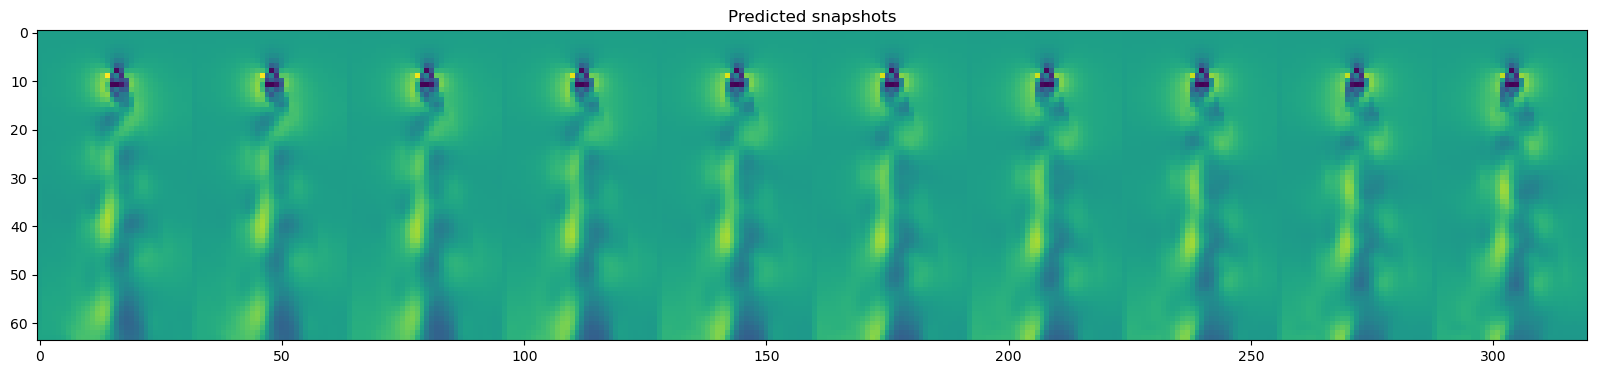

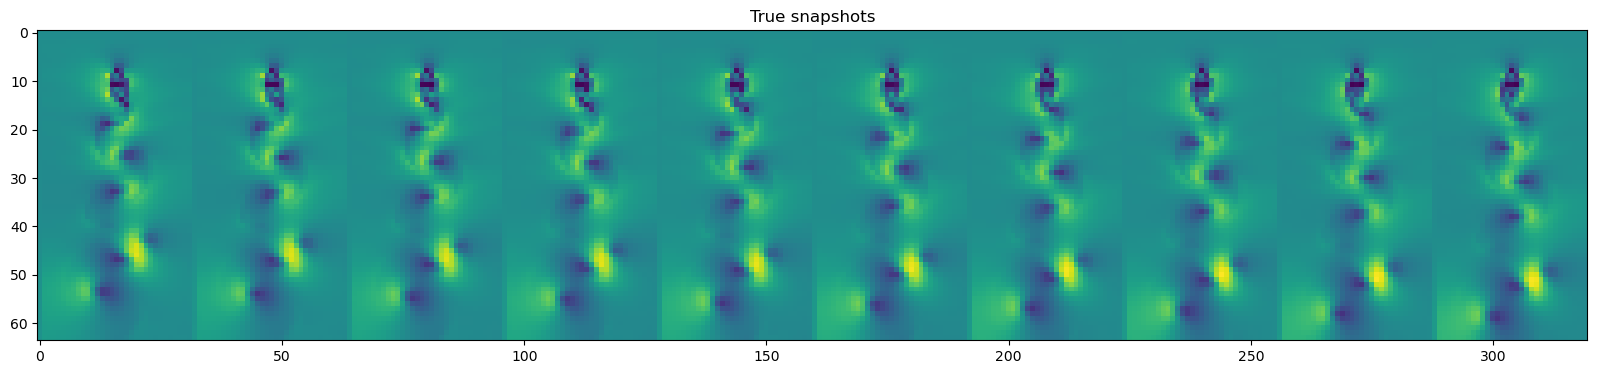

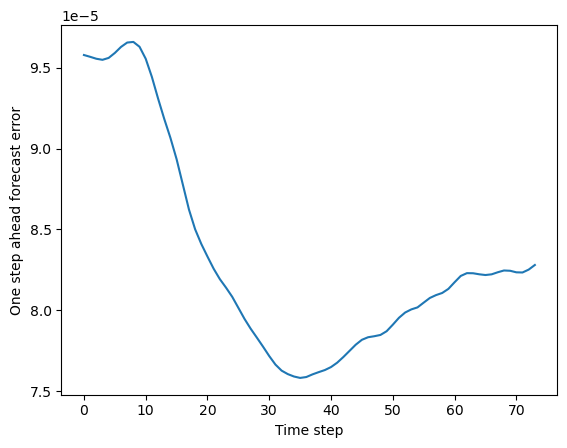

In [19]:
dataset= ForecastingDataset(vfield_mag)

# Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=1.0)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")


mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")